In [1]:
from utils.read_datasetBreakfast import load_data, read_mapping_dict
import os
import numpy as np


COMP_PATH = ''

''' 
training to load train set
test to load test set
'''
split = 'training'
#split = 'test'
train_split =  os.path.join(COMP_PATH, 'splits/dev_train.split1.bundle') #Train Split
test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video 
DATA_folder =  os.path.join(COMP_PATH, 'Data/') #Frame I3D features for all videos
mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt') 

actions_dict = read_mapping_dict(mapping_loc)

data_feat, data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = split) #Get features and labels

Finish Load the Training data and labels!!!


In [2]:
validation_split = os.path.join(COMP_PATH, 'splits/val.split1.bundle') #Validation split
val_data_feat, val_data_labels = load_data( validation_split, actions_dict, GT_folder, DATA_folder, datatype = split) #Get features and labels

Finish Load the Training data and labels!!!


In [15]:
import torch
def splitByFrames(data_feat, data_labels, frames_per_clip):
    new_data_feat = []
    new_data_labels = []
    for i in range(0, len(data_feat)):
        total_frames, dim = data_feat[i].shape
        segment = data_feat[i]
        if total_frames % frames_per_clip != 0:
            pad_num = frames_per_clip - total_frames % frames_per_clip
            pad_Tensor = torch.zeros((pad_num, 400), dtype=torch.float64)
            segment = torch.cat((segment, pad_Tensor))
        total_frames, dim = segment.shape
        clip_num = int(total_frames / frames_per_clip)
        clips = segment.view(-1, frames_per_clip, 400)
    
        label = data_labels[i]
        new_data_labels += [label] * clip_num
        new_data_feat.append(clips)

    new_data_feat = torch.cat(new_data_feat)
    return new_data_feat, new_data_labels

#new_data_feat, new_data_labels = splitByFrames(data_feat, data_labels, 16)
#val_data_feat, val_data_labels = splitByFrames(val_data_feat, val_data_labels, 16)

In [2]:
import torch
from Dataset.VideoDataset import VideoDataset, VideoTrainDataset
import torch.utils.data as tud
from Models.LSTM import LSTM_Model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch.nn.utils as u

epochs = 1
batch_size = 50


learning_rate = 1e-3
log_interval = 30

def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    
    losses = []
    scores = []
    for batch_idx, (in_feature, label, seq_length) in enumerate(train_loader):
        in_feature = in_feature.to(device)
        label = label.to(device)
        seq_length = seq_length.to(device)
        packed_input = u.rnn.pack_padded_sequence(in_feature, seq_length, batch_first=True, enforce_sorted=False).to(device)
        
        optimizer.zero_grad()
        output = model(packed_input)
        loss = F.cross_entropy(output, label)
        losses.append(loss.item())
        
        label_predict = torch.max(output, 1)[1]
        step_score = accuracy_score(label.cpu().data.squeeze().numpy(), label_predict.cpu().data.squeeze().numpy())
        scores.append(step_score)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, (batch_idx+1)*batch_size, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))
        
    return losses, scores

In [8]:
val_dataset = VideoDataset(val_data_feat, val_data_labels)
val_dataloader = tud.DataLoader(val_dataset)

def validation(model, device, test_loader):
    model.eval()
    
    all_labels = []
    all_labels_predict = []
    with torch.no_grad():
        for in_feature, labels in test_loader:
            in_feature = in_feature.to(device)
            labels = labels.to(device)
            packed_input = u.rnn.pack_padded_sequence(in_feature, torch.LongTensor([in_feature.shape[1]]),batch_first=True, enforce_sorted=False).to(device)
            
            output = model(packed_input)
            
            labels_predict = torch.max(output, 1)[1]
            all_labels.extend(labels)
            all_labels_predict.extend(labels_predict.long())
            
    # compute accuracy
    all_labels = torch.stack(all_labels, dim=0)
    all_labels_predict = torch.stack(all_labels_predict, dim=0)
    test_score = accuracy_score(all_labels.cpu().data.squeeze().numpy(), all_labels_predict.cpu().data.squeeze().numpy())
    print('\nTest set ({:d} samples): Accuracy: {:.2f}%\n'.format(len(all_labels), 100* test_score))
    
    return test_score

In [3]:
import utils.balance_data as b
cuda_avail = torch.cuda.is_available()
device = torch.device("cuda" if cuda_avail else "cpu")

lstm = LSTM_Model(hidden_rnn_layers = 2, hidden_rnn_nodes = 368, bidirectional=True, fc_dim=256).double().to(device)
optimizer = torch.optim.Adam(list(lstm.parameters()), lr=learning_rate, weight_decay = 1e-6)

# record training process
epoch_train_losses = []
epoch_train_scores = []
epoch_test_scores = []

label_dict = b.generate_label_dictionary(data_feat, data_labels)
total_segments = len(data_labels)
for epoch in range(epochs):
    new_data_feat, new_data_labels = b.balance_data(label_dict, total_segments)
    dataset = VideoTrainDataset(new_data_feat, new_data_labels, 50)
    dataloader = tud.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    train_losses, train_scores = train(log_interval, lstm, device, dataloader, optimizer, epoch)
    
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    #if epoch % 20 == 0:
        #test_score = validation(lstm, device, val_dataloader)
        #epoch_test_scores.append(test_score)

torch.save(model.state_dict(), "./trained/lstm.pt")
A = np.array(epoch_train_losses)
B = np.array(epoch_train_scores)
D = np.array(epoch_test_scores)
np.save('./results/lstm/training_losses_2.npy', A)
np.save('./results/lstm/training_scores_2.npy', B)
#np.save('./results/lstm/test_loss.npy', C)
np.save('./results/lstm/test_score.npy', D)
    


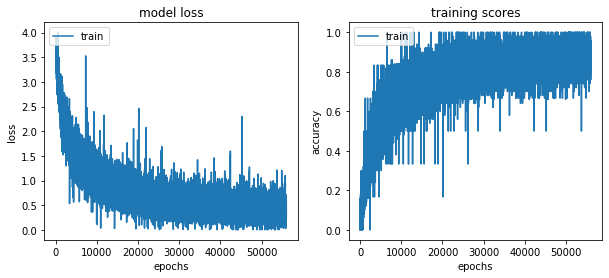

In [2]:
import matplotlib.pyplot as plt
import numpy as np

A = np.load('./results/lstm/training_losses2_2020-04-04.npy')
B = np.load('./results/lstm/training_scores2_2020-04-04.npy')

#C = np.load('./results/lstm/test_loss_2020-03-28.npy')
#D = np.load('./results/lstm/test_score_2020-03-29.npy')
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
#plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.plot(A.flatten())  # train loss (on epoch end)
#plt.plot(np.arange(1, epochs + 1), C)  
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'], loc="upper left")
# 2nd figure
plt.subplot(122)
#plt.plot(np.arange(1, epochs + 1), B[:, -1])
plt.plot(B.flatten())

epochs = 100
#plt.plot(D) # train accuracy (on epoch end)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper left")
plt.show()

In [3]:
print(D)


[0.19069413 0.25553013 0.27002288 0.33790999 0.32951945 0.39740656
 0.39588101 0.41952708 0.40732265 0.45842868 0.43935927 0.41342487
 0.43554539 0.44088482 0.4546148  0.44393593 0.44393593 0.46147979
 0.4546148  0.46224256 0.4546148  0.47368421 0.4576659  0.45385202
 0.45614035 0.45614035 0.42715484 0.44241037 0.43478261 0.44393593
 0.43707094 0.4446987  0.46071701 0.41800153 0.42562929 0.46834477
 0.45995423 0.43096873 0.43401983 0.46071701]
